### 2024-04-25 外れ値を定義する

In [1]:
import pandas as pd
import numpy as np
import requests
import io
import math
import copy
from scipy.stats import gmean
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import patches
from pipeline_functions import PipelineFunctions
pf = PipelineFunctions()
from view_functions import ViewFunction
vf = ViewFunction()

##### ▶データを読み込む

In [2]:
# URLを指定したドローイングの、指定した順番のストロークの形状を描画する関数
def draw_stroke(url, rotate_type, drawing_id, stroke_id, path):
    class PreprocessedData():
        def __init__(self, url, rotate_type):
            self.CANVAS_HEIGHT = 297
            self.CANVAS_WIDTH = 420
            self.MAX_POINT = 943
            self.NORM_DIVISOR = 3
            self.columns = [ 'time', 'alpha', 'max_points', 'ptx_anoto', 'pty_anoto', 'shape_str',
                        'pressure_style', 'len_mm_acc', 'len_anoto', 'pressure_avg', 'shape_int']
            self.BIN_HEIGHT = 420
            self.BIN_WIDTH = 420
            
            self.df_org = None
            self.df_mm = None
            self.df_remove_overlap = None
            
            self.url = url
            self.rotate_type = rotate_type
            
            # urlからデータを作成
            self.get_df(self.url)
            self.conv_str_to_coord()

            self.remove_overlap_coord()
            ################################
            
        # URLからデータフレームを取得 & ストローク長の列を追加
        def get_df(self, url):
            content = requests.get(url, auth=('19t2003a', 'ireneRED77')).content
            df = pd.read_table(io.StringIO(content.decode('utf-8')), header = None)
            df.columns = self.columns
            st_len_mm = [l*0.3 for l in df['len_anoto']]
            df['len_mm'] = st_len_mm
            # ストローク固有のidを付与
            df_reindex = df.reset_index()
            df_reindex = df_reindex.rename(columns={'index': 'stroke_id'})
            
            self.df_org = df_reindex.copy()
            
        # 文字列座標データをリストに変換 & anotoから普通座標に変換
        def conv_str_to_coord(self):
            df = self.df_org.copy()
            x_list = []
            y_list = []
            for str_x, str_y in zip(df['ptx_anoto'], df['pty_anoto']):
                x_list.append([float(x)*0.3 for x in str_x.split(',')])
                y_list.append([float(y)*0.3 for y in str_y.split(',')])
            df['ptx_mm'] = x_list
            df['pty_mm'] = y_list
            self.df_mm = df
        
        # 重複している座標を排除
        def remove_overlap_coord(self):
            df = self.df_mm.copy()
            
            org_ptxs = df['ptx_mm']
            org_ptys = df['pty_mm']
            remove_indexs = []
            for ptxs, ptys in zip(org_ptxs, org_ptys):
                remove_index = []
                for i in range(1, len(ptxs)):
                    if ptxs[i] == ptxs[i-1] and ptys[i] == ptys[i-1]:
                        remove_index.append(i)
                    else:
                        pass
                remove_indexs.append(remove_index)
            
            df['remove_index'] = remove_indexs
            
            remove_overlap_ptxs = []
            remove_overlap_ptys = []
            for ptxs, ptys, remove_index in zip(org_ptxs, org_ptys, df['remove_index']):
                remove_overlap_ptx = [ ptxs[i] for i in range(len(ptxs)) if i not in remove_index]
                remove_overlap_pty = [ ptys[i] for i in range(len(ptys)) if i not in remove_index]
                remove_overlap_ptxs.append(remove_overlap_ptx)
                remove_overlap_ptys.append(remove_overlap_pty)    
            
            df['ptx_mm'] = remove_overlap_ptxs
            df['pty_mm'] = remove_overlap_ptys
            
            self.df_remove_overlap = df

    # --- グラフ描画 ---#
    data = PreprocessedData(url, rotate_type)
    df = data.df_remove_overlap
    
    STROKE_COLOR = 'black'
    STROKE_WIDTH = 1
    FIG_WIDTH = 10
    FIG_HEIGHT = 10
    
    
    plt.rcParams['font.family'] = 'MS Gothic'
    fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT), facecolor='white')
    
    x = df.query('stroke_id == @stroke_id')['ptx_mm'].iloc[-1]
    y = df.query('stroke_id == @stroke_id')['pty_mm'].iloc[-1]
    
    ax.plot(x, y, color=STROKE_COLOR, linewidth=STROKE_WIDTH)
    ax.scatter(x, y, color=STROKE_COLOR, marker='.')
    
    title = f'{drawing_id}_{stroke_id}_coordsize-{len(x)}'
    ax.set_title(title)
    # plt.savefig(f'{path}/{drawing_id}_{stroke_id}.png')
    plt.show()
    plt.close()
    return

In [3]:
# 箱ひげ図を作成する
def boxviolinplot(plot_list, label, ymin, ymax):
    title = ''
    plt.rcParams['font.family'] = 'MS Gothic'
    FIG_WIDTH = 15
    FIG_HEIGHT = 7
    fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT), facecolor='white')
    ax.set_ylim(ymin, ymax)
    ax.grid(True)
    ax.set_xticklabels(label)

    ax.set_title(title)
    
    # ax.boxplot(plot_list, whis=(0, 100))
    # ax.boxplot(plot_list, whis=(5, 95))
    
    ax.boxplot(plot_list, whis=1.5)
    
    # ax.violinplot(plot_list)
    
    plt.show()
    plt.close()
    return

In [16]:
# 成果物を描画する
def draw_all_stroke(xs, ys, rotate_type, did, sid, ptcnt):
    # グラフ用パラメータを定義する
    WIDTH = 420
    HEIGHT = 297
    SCALE = 0.015
    STROKE_WIDTH = 0.5
    PLOT_SIZE = 1
    STROKE_COLOR = 'black'
    FACE_COLOR = 'white'
    plt.rcParams['font.family'] = 'Times New Roman'
    # ===== コメントアウトで軸を消去する ===== #
    # plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False, 
    #                 bottom=False, left=False, right=False, top=False)
    # ===================================== #
    
    
    # 回転方向によって用紙の向きを変える
    if rotate_type == 0 or rotate_type ==180:
        FIG_SIZE = (WIDTH*SCALE, HEIGHT*SCALE)
    else:
        FIG_SIZE = (HEIGHT*SCALE, WIDTH*SCALE)
    
    fig, ax = plt.subplots(facecolor=FACE_COLOR, figsize=(FIG_SIZE[0],FIG_SIZE[1]))
    
    if rotate_type == 0 or rotate_type ==180:
        ax.set_xlim([0, WIDTH])    # x方向の描画範囲を指定
        ax.set_ylim([0, HEIGHT])    # y方向の描画範囲を指定
    else:
        ax.set_xlim([0, HEIGHT])    # x方向の描画範囲を指定
        ax.set_ylim([0, WIDTH])    # y方向の描画範囲を指定
        
    # ストロークを描画する
    # for x, y in zip(xs, ys):
        # ax.plot(x, y, color=STROKE_COLOR, linewidth=STROKE_WIDTH)
    ax.plot(xs, ys, color=STROKE_COLOR, linewidth=STROKE_WIDTH)
    ax.scatter(xs, ys, color=STROKE_COLOR, s=PLOT_SIZE)
    
    ax.set_facecolor(FACE_COLOR)
    
    # ===== y軸の向きをデータ収集系に揃える（必須!!!） ===== #
    ax.invert_yaxis()
    # =================================================== #
    plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False, 
                        bottom=False, left=False, right=False, top=False)
    # plt.savefig(f'../temp/complex/{ptcnt}_id_{did}_{sid}.png')
    plt.show()
    plt.close()
    return

In [2]:
def draw_one_stroke(x, y, rotate_type, did, sid, ptcnt):
        # グラフ用パラメータを定義する
        CANVAS_COLOR = 'white'
        STROKE_COLOR = 'black'
        STROKE_WIDTH = 1
        SCALE = 0.015
        PLOT_SIZE = 5
        plt.rcParams['font.family'] = 'MS Gothic'
        
        # 回転方向によって用紙の向きを変える
        if rotate_type == 0 or rotate_type == 180:
            X_MIN = 0
            X_MAX = 420
            Y_MIN = 0
            Y_MAX = 297
        else:
            X_MIN = 0
            X_MAX = 297
            Y_MIN = 0
            Y_MAX = 420
        
        fig, ax = plt.subplots(figsize=((X_MAX - X_MIN)*SCALE, (Y_MAX - Y_MIN)*SCALE), facecolor='white')
        ax.set_facecolor(CANVAS_COLOR)
        
        # # 座標の始点を用紙の中心(X_MAX/2, Y_MAX/2)にする
        # x_plot = [(c - x[0])*STROKE_SCALE + (X_MAX-X_MIN)/2 for c in x]
        # y_plot = [(c - y[0])*STROKE_SCALE + (Y_MAX-Y_MIN)/2 for c in y]
        
        # 座標の外包矩形が接するように拡大する
        x_slide_ex = []
        y_slide_ex = []
        x_min, x_max, y_min, y_max = min(x), max(x), min(y), max(y)
        x_range = x_max - x_min
        y_range = y_max - y_min
        x_slide = [float(c) - x_min for c in x]
        y_slide = [float(c) - y_min for c in y]
        
        # ストローク座標が1点しかない場合は，拡大はせず原点にスライドするだけ
        if x_range == 0 and y_range == 0:
            x_slide_ex = x_slide
            y_slide_ex = y_slide
        # ありえないが，一応，ストロークが寸分違わず垂直の場合を考慮
        elif x_range == 0:
            y_ratio = (Y_MAX - Y_MIN) / y_range
            x_slide_ex = [float(x) * y_ratio for x in x_slide]
            y_slide_ex = [float(y) * y_ratio for y in y_slide]
        # ありえないが，一応，ストロークが寸分違わず水平の場合を考慮
        elif y_range == 0 :
            x_ratio = (X_MAX - X_MIN) / x_range
            x_slide_ex = [float(x) * x_ratio for x in x_slide]
            y_slide_ex = [float(y) * x_ratio for y in y_slide]
        else :
            x_ratio = (X_MAX - X_MIN) / x_range
            y_ratio = (Y_MAX - Y_MIN) / y_range
            if x_ratio <= y_ratio :
                x_slide_ex = [float(x) * x_ratio for x in x_slide]
                y_slide_ex = [float(y) * x_ratio for y in y_slide]
            elif x_ratio > y_ratio :
                x_slide_ex = [float(x) * y_ratio for x in x_slide]
                y_slide_ex = [float(y) * y_ratio for y in y_slide]
            else :
                pass
            
        x_plot = x_slide_ex
        y_plot = y_slide_ex
        
        
        # 軸の大きさ
        MARGIN_MM = 5
        ax.set_xlim(X_MIN-MARGIN_MM, X_MAX+MARGIN_MM)
        ax.set_ylim(Y_MIN-MARGIN_MM, Y_MAX+MARGIN_MM)
        
        ax.plot(x_plot, y_plot, color=STROKE_COLOR, linewidth=STROKE_WIDTH)
        ax.scatter(x_plot, y_plot, color=STROKE_COLOR, s=PLOT_SIZE)
        # ax.scatter(x_plot[:1], y_plot[:1], color='orange', s=200)
        
        ax.invert_yaxis()
        plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False, 
                        bottom=False, left=False, right=False, top=False)
        plt.savefig(f'../temp/complex/{ptcnt}_id_{did}_{sid}.png')
        # plt.show()
        plt.close()
        return

In [3]:
coord_size = pd.read_csv('../temp/coord_size_alldrawing.csv', index_col=0)
coord_size_each = pd.read_pickle('../temp/20240216_coordsize.pkl')

##### ▶座標数の分布

In [5]:
# boxviolinplot(coord_size['coord_sizes_remove_overlap'], ['座票数'], 0, 20)

##### ▶上側95, 99%を外れ値とする

In [6]:
###################
trim_percentile = 99
###################

# 座票数を大きい順に並べ替える
sorted_coordsize = sorted(coord_size['coord_sizes_remove_overlap'].to_list(), reverse=False)
# 区切る場所を設定する
trim_point = int(len(sorted_coordsize) / 100 * trim_percentile)
# トリム後の座標数
trimmed_coordsize = sorted_coordsize[:trim_point]
# トリム後の座標数の最大値
max_in_trim = max(trimmed_coordsize)
print(max_in_trim)

83


##### ▶99%以内のデータにも，最大座標数83が含まれているので83も診断対象として含める

In [7]:
# 座標数が83以下のストローク（線種判定の診断対象）
coordsize_below83 = [val for val in sorted_coordsize if val <= 83]
print(len(coordsize_below83))

2041566


##### ▶パイプライン用クラスを使って再現性を確認する

In [4]:
# 浅井の解析対象データ
target_info = pd.read_excel('../data/all_drawing_info.xlsx', index_col=0).query('is_asai == 1')

In [5]:
drawing_ids = []
rotate_types = []
stroke_ids = []
shapes = []
rotated_xs = []
rotated_ys = []
normalized_xs = []
normalized_ys = []

for did in target_info['drawing_id']:
    # 重複なし，回転済み，サイズ正規化済みのdfを取得
    rotate_type = target_info.query('drawing_id == @did')['rotate_type'].iloc[0]
    df = pf.get_normalized_data(f'../data/all_tsv/id_{did}.tsv', rotate_type)
    
    for sid, shape, rx, ry, nx, ny in zip(
    df['stroke_id'], df['shape_int'], 
    df['rotated_x'], df['rotated_y'], 
    df['size_unified_x'], df['size_unified_y']
    ):
        drawing_ids.append(did)
        rotate_types.append(rotate_type)
        stroke_ids.append(sid)
        shapes.append(shape)
        rotated_xs.append(rx)
        rotated_ys.append(ry)
        normalized_xs.append(nx)
        normalized_ys.append(ny)
        
coordsizes = [len(coord) for coord in rotated_xs]
df_all = pd.DataFrame({
    'drawing_id': drawing_ids, 
    'stroke_id': stroke_ids,
    'shape_int': shapes,
    'rotate_type': rotate_types,
    'pt_cnt': coordsizes,
    'rotated_x': rotated_xs,
    'rotated_y':rotated_ys,
    'normalized_x': normalized_xs,
    'normalized_y': normalized_ys
})

##### ▶すべての解析対象ストローク(座票数が83以下のストローク)

In [5]:
MAX_PT_CNT = 83
print('座標数が83個以下のストローク', len(df_all.query('pt_cnt <= @MAX_PT_CNT')))

座標数が83個以下のストローク 2041566


##### ▶座標数が83より大きい線が既存の線種判定で複雑線と判定されているかを確認する

(array([  243.,     0., 18266.,     0.,  1825.]),
 array([2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 5 artists>)

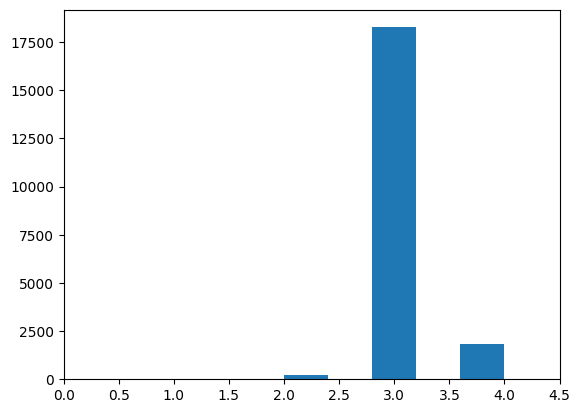

In [6]:
MAX_PT_CNT = 83
df_over83 = df_all.query('pt_cnt > @MAX_PT_CNT')
plt.xlim([0, 4.5])
plt.hist(df_over83['shape_int'], bins = 5)

##### ▶ストロークを描画して形状を確認する

In [22]:
# # 曲線
# curve = df_over83.query('shape_int == 2')
# # 複雑線
# complex = df_over83.query('shape_int == 3')
# # ハッチング
# hatching = df_over83.query('shape_int == 4')

# # ストロークを描画して保存する
# show_shape = curve[0:10]
# cnt = 0
# for x, y, rotate_type, did, sid, ptcnt in zip(
#     show_shape['rotated_x'], show_shape['rotated_y'], show_shape['rotate_type'],
#     show_shape['drawing_id'], show_shape['stroke_id'], show_shape['pt_cnt']
# ):
#     draw_all_stroke(x, y, rotate_type, did, sid, ptcnt)
#     print(cnt)
#     cnt += 1

##### ▶外包矩形の面積と座標数の相関を確認する⇒相関なし

In [33]:
# def calc_stroke_area(x, y):
#     x_min, x_max, y_min, y_max = min(x), max(x), min(y), max(y)
#     x_range = x_max - x_min
#     y_range = y_max - y_min
#     return x_range * y_range
# stroke_areas = []
# for x, y in zip(df_all['rotated_x'], df_all['rotated_y']):
#     stroke_areas.append(calc_stroke_area(x, y))

# stroke_areas = []
# for x, y in zip(df_all['rotated_x'], df_all['rotated_y']):
#     stroke_areas.append(calc_stroke_area(x, y))
# plt.scatter(df_all['pt_cnt'][:2000], stroke_areas[:2000])

##### ▶判定対象外ストロークを除いた各ドローイングのストローク数を確認する

In [42]:
MAX_PT_CNT = 83
df_below83 = df_all.query('pt_cnt <= @MAX_PT_CNT')
dids = []
org_stcnt = []
below83_stcnt = []

for did in target_info['drawing_id']:
    org_each = df_all.query('drawing_id == @did')
    below83_each = df_below83.query('drawing_id == @did')
    
    dids.append(did)
    org_stcnt.append(len(org_each))
    below83_stcnt.append(len(below83_each))

In [78]:
stcnt = pd.DataFrame({
    'drawing_id': dids,
    'org_stcnt': org_stcnt,
    'below83_stcnt': below83_stcnt
})

# ストローク数の差
diff_stcnt = [o - b for o, b in zip(stcnt['org_stcnt'], stcnt['below83_stcnt'])]
# ストローク数の割合
ratio_stcnt = [b / o for o, b in zip(stcnt['org_stcnt'], stcnt['below83_stcnt'])]
# もともとのストローク数に対する，ストローク数の差の割合
ratio_org_diff = [d / o for o, d in zip(stcnt['org_stcnt'], diff_stcnt)]

stcnt = pd.DataFrame({
    'drawing_id': dids,
    'org_stcnt': org_stcnt,
    'below83_stcnt': below83_stcnt,
    'diff': diff_stcnt,
    'ratio': ratio_stcnt,
    'ratio_org_diff': ratio_org_diff
})


In [3]:
# plt.hist([stcnt['org_stcnt'], stcnt['below83_stcnt']])
# plt.hist(diff_stcnt, bins=20)
# plt.hist(ratio_stcnt, bins=100)
# print('割合(診断対象ストローク数 / もともとのストローク数) の幾何平均 | ', gmean(ratio_stcnt))
# from scipy.stats import ttest_1samp
# ストローク数の差の検定
# ttest_1samp(diff_stcnt, popmean=0)
# ストローク数の割合の検定
# ttest_1samp(ratio_stcnt, popmean=1)

##### ▶各ドローイングの99%座票数を確認する

In [86]:
TRIM_PERCENTILE = 99
org_max_ptcnts = []
trimmed_ptcnts = []
for did in target_info['drawing_id']:
    ptcnt_each = df_all.query('drawing_id == @did')['pt_cnt']
    
    # 座票数を大きい順に並べ替える
    sorted_ptcnt = sorted(ptcnt_each.to_list(), reverse=False)
    # 区切る場所を設定する
    trim_point = int(len(sorted_ptcnt) / 100 * TRIM_PERCENTILE)
    # トリム後の座標数
    trimmed_ptcnt = sorted_ptcnt[:trim_point]
    # トリム後の座標数の最大値
    max_trim_ptcnt = max(trimmed_ptcnt)
    trimmed_ptcnts.append(max_trim_ptcnt)

In [88]:
stcnt['trimmed_ptcnt'] = trimmed_ptcnts

52

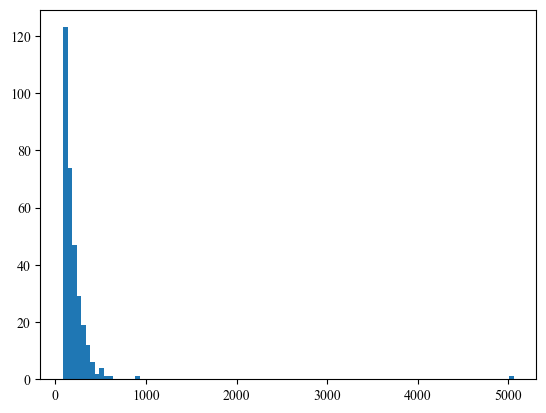

In [98]:
plt.hist([val for val in stcnt['trimmed_ptcnt'] if val > 83], bins=100)
# plt.hist(stcnt['trimmed_ptcnt'], bins=20)

import statistics
statistics.median(stcnt['trimmed_ptcnt'])

##### ▶すべてのストロークを100個ごとに分けて標本平均を算出

(array([ 3.,  6., 13., 19., 36., 40., 29., 16., 22., 14.,  2.,  4.,  0.,
         1.,  1.]),
 array([ 9.46518134,  9.56049555,  9.65580977,  9.75112399,  9.84643821,
         9.94175242, 10.03706664, 10.13238086, 10.22769507, 10.32300929,
        10.41832351, 10.51363773, 10.60895194, 10.70426616, 10.79958038,
        10.89489459]),
 <BarContainer object of 15 artists>)

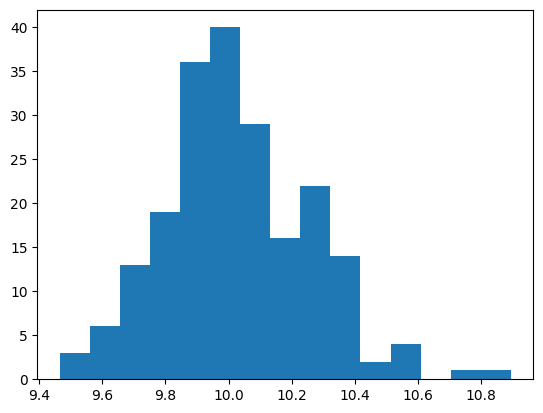

In [19]:
import statistics
seed = 31
n = 206 # 座標数のリストをn分割

df_all_shuffle = df_all.sample(frac=1, random_state=seed)
ptcnts = df_all_shuffle['pt_cnt'].to_list()

splited_ptcnts = [ptcnts[i::n] for i in range(n)]
ptcnt_means = [statistics.mean(arr) for arr in splited_ptcnts]

plt.hist(ptcnt_means, bins=15)

##### ▶線種ごとの座標数を確認する

In [93]:
pt = df_all.query('shape_int == 0')
st = df_all.query('shape_int == 1')
cu = df_all.query('shape_int == 2')
co = df_all.query('shape_int == 3')
ha = df_all.query('shape_int == 4')
print(len(pt)/len(df_all))
print(len(st)/len(df_all))
print(len(cu)/len(df_all))
print(len(co)/len(df_all))
print(len(ha)/len(df_all))

0.07688879189097435
0.46147873320723604
0.38269751200349195
0.04806052669867598
0.03087443619962171


In [110]:
# それぞれの座標数の頻度を確認する
df_nopt = df_all.query('shape_int != 0')
all_cnt = [[p, len(df_all.query('pt_cnt == @p'))] for p in np.sort(df_all['pt_cnt'].unique())]
nopt_cnt = [[p, len(df_nopt.query('pt_cnt == @p'))] for p in np.sort(df_nopt['pt_cnt'].unique())]
pt_cnt = [[p, len(pt.query('pt_cnt == @p'))] for p in np.sort(pt['pt_cnt'].unique())]
st_cnt = [[p, len(st.query('pt_cnt == @p'))] for p in np.sort(st['pt_cnt'].unique())]
cu_cnt = [[p, len(cu.query('pt_cnt == @p'))] for p in np.sort(cu['pt_cnt'].unique())]
co_cnt = [[p, len(co.query('pt_cnt == @p'))] for p in np.sort(co['pt_cnt'].unique())]
ha_cnt = [[p, len(ha.query('pt_cnt == @p'))] for p in np.sort(ha['pt_cnt'].unique())]

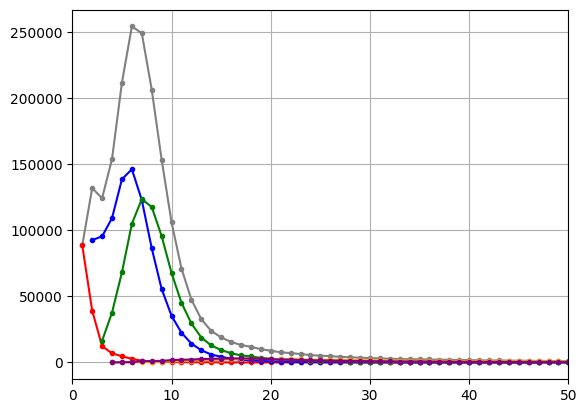

In [140]:
plt.xlim([0, 50])
plt.grid()
plt.plot([arr[0] for arr in all_cnt], [arr[1] for arr in all_cnt], marker='.', color='gray')
# plt.plot([arr[0] for arr in nopt_cnt], [arr[1] for arr in nopt_cnt], marker='.')

plt.plot([arr[0] for arr in pt_cnt], [arr[1] for arr in pt_cnt], marker='.', color='red')
plt.plot([arr[0] for arr in st_cnt], [arr[1] for arr in st_cnt], marker='.', color='blue')
plt.plot([arr[0] for arr in cu_cnt], [arr[1] for arr in cu_cnt], marker='.', color='green')
plt.plot([arr[0] for arr in co_cnt], [arr[1] for arr in co_cnt], marker='.', color='orange')
plt.plot([arr[0] for arr in ha_cnt], [arr[1] for arr in ha_cnt], marker='.', color='purple')
